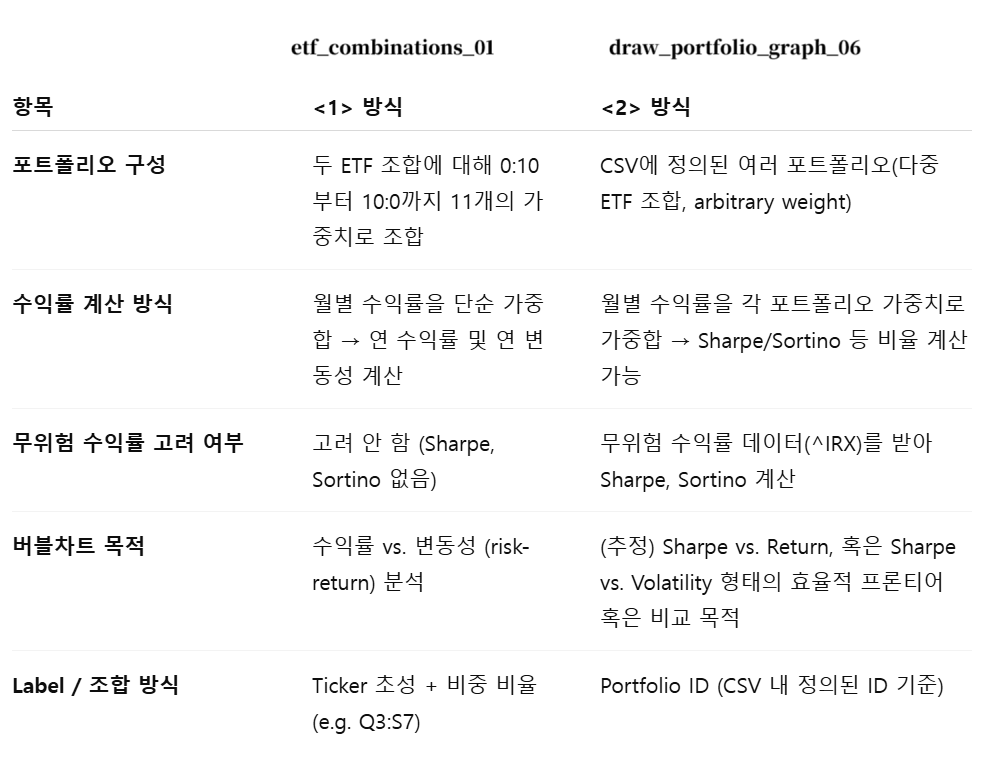

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "C:\Windows\Fonts\malgun.ttf"  # Windows 기본 Malgun Gothic 경로
font_name = fm.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import pandas as pd
import numpy as np
import os
import yfinance as yf

def load_portfolio_returns(portfolio_file, monthly_return_folder):
    portfolios = pd.read_csv(portfolio_file)
    etfs = portfolios.columns.tolist()
    etfs.remove('Portfolio ID') 

    returns_list = []
    for etf in etfs:
        file_path = os.path.join(monthly_return_folder, f"{etf}_monthly_return.csv")
        df = pd.read_csv(file_path, parse_dates=['Date'])
        df.rename(columns={'Monthly Return': etf}, inplace=True)
        returns_list.append(df.set_index('Date'))

    returns_df = pd.concat(returns_list, axis=1)

    portfolio_returns = pd.DataFrame(index=returns_df.index)
    for idx, row in portfolios.iterrows():
        weights = row[1:]  # 'Portfolio ID' 제외한 비중
        portfolio_id = row['Portfolio ID']
        portfolio_returns[portfolio_id] = returns_df.mul(weights, axis=1).sum(axis=1)

    # 날짜를 컬럼으로 넣어 저장할 때 필요하므로 인덱스 리셋
    portfolio_returns = portfolio_returns.reset_index()
    return portfolio_returns

def download_and_clean_rf_rate(save_path="us_3m_treasury_rate_1998_2025_cleaned.csv"):
    ticker = "^IRX"
    start_date = "1998-02-01"
    end_date = "2025-05-31"

    irx = yf.Ticker(ticker)
    hist = irx.history(start=start_date, end=end_date)
    monthly_irx = hist['Close'].resample('ME').last() / 100  # % -> 소수 변환

    df_monthly_irx = monthly_irx.reset_index()
    df_monthly_irx.columns = ['Date', '3M_Treasury_Rate']

    # 시간대 제거
    df_monthly_irx['Date'] = pd.to_datetime(df_monthly_irx['Date'], utc=True)
    df_monthly_irx['Date'] = df_monthly_irx['Date'].dt.tz_convert(None)
    df_monthly_irx['Date'] = df_monthly_irx['Date'].dt.date

    df_monthly_irx.to_csv(save_path, index=False)
    print(f"무위험 수익률 데이터 저장 완료: {save_path}")
    return save_path

def calculate_ratios(portfolio_returns_file, rf_file, output_prefix):
    portfolio = pd.read_csv(portfolio_returns_file, parse_dates=['Date'])
    rf = pd.read_csv(rf_file)
    rf['Date'] = pd.to_datetime(rf['Date'], errors='coerce')

    if rf['Date'].dt.tz is not None:
        rf['Date'] = rf['Date'].dt.tz_localize(None)

    df = pd.merge(portfolio, rf, on='Date', how='inner')
    df['rf_monthly'] = df['3M_Treasury_Rate'] / 12

    portfolio_cols = [col for col in df.columns if col not in ['Date', '3M_Treasury_Rate', 'rf_monthly']]

    def sharpe_ratio(returns, rf_rate):
        mean_excess_return = (returns - rf_rate).mean()
        std_dev = (returns - rf_rate).std()
        if std_dev == 0:
            return np.nan
        return (mean_excess_return / std_dev) * np.sqrt(12)

    def sortino_ratio(returns, rf_rate):
        excess_returns = returns - rf_rate
        downside_std = excess_returns[excess_returns < 0].std()
        mean_excess_return = excess_returns.mean()
        if downside_std == 0:
            return np.nan
        return (mean_excess_return / downside_std) * np.sqrt(12)

    sharpe_list = []
    sortino_list = []

    for col in portfolio_cols:
        r = df[col]
        rf_rate = df['rf_monthly']
        sharpe_list.append(sharpe_ratio(r, rf_rate))
        sortino_list.append(sortino_ratio(r, rf_rate))

    results_df = pd.DataFrame({
        'Portfolio': portfolio_cols,
        'Sharpe Ratio': sharpe_list,
        'Sortino Ratio': sortino_list
    })

    results_df.to_csv(f'{output_prefix}_ratios.csv', index=False)
    print(f"{output_prefix}_ratios.csv 저장 완료")

def calc_annualized_metrics(df, portfolios):
    """
    <1> 방식으로 연 수익률과 연 변동성 계산
    - df: Date 컬럼 포함, 월별 수익률이 각 포트폴리오 컬럼에 있음
    - portfolios: 포트폴리오 컬럼명 리스트
    """
    df = df.copy()
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)

    results = []

    for p in portfolios:
        # 해당 포트폴리오 월별 수익률 시리즈
        port_ret = df[p].dropna()

        # 1) 연별 누적 수익률 계산: (1 + r) 곱, -1 해서 연별 수익률 계산
        ann_returns = (1 + port_ret).resample('YE').prod() - 1

        # 연 수익률은 연별 수익률들의 평균 * 100 (%)
        annual_return = ann_returns.mean() * 100

        # 2) 연별 월별 수익률 표준편차 구해서 연 변동성 산출
        # 포트폴리오 월별 수익률을 연별로 리샘플링하여 연도별 변동성 계산 후 평균
        # (연별 월별 표준편차) * sqrt(12) * 100
        # => 월별 표준편차를 연 단위 변동성으로 환산
        annual_volatility = port_ret.resample('YE').std().mean() * np.sqrt(12) * 100

        results.append({
            'Portfolio': p,
            'Annualized Return (%)': annual_return,
            'Annualized Volatility (%)': annual_volatility
        })

    return pd.DataFrame(results)


if __name__ == "__main__":
    monthly_return_folder = 'monthly_return'

    # 1) 무위험 수익률 데이터 다운로드 및 저장 (처음 1회만 실행)
    rf_file = download_and_clean_rf_rate()

    # 2) portfolio 후보 처리
    folio_returns = load_portfolio_returns('portfolio_candidates06.csv', monthly_return_folder)
    folio_returns.to_csv('portfolio06_returns.csv', index=False, encoding='utf-8-sig')

    # 3) 샤프, 소르티노 지수 계산
    calculate_ratios('portfolio06_returns.csv', rf_file, 'portfolio06')

    # 4) 연환산 수익률, 변동성 계산 (<1> 방식으로 변경)
    folio_df = pd.read_csv('portfolio06_returns.csv', parse_dates=['Date'])
    portfolios06 = [col for col in folio_df.columns if col != 'Date']

    folio06_metrics = calc_annualized_metrics(folio_df, portfolios06)

    print("Portfolio06 Annualized Metrics (Modified Calculation):")
    print(folio06_metrics.head())

    # 필요시 CSV 저장
    folio06_metrics.to_csv('portfolio06_annual_metrics.csv', index=False)

무위험 수익률 데이터 저장 완료: us_3m_treasury_rate_1998_2025_cleaned.csv
portfolio06_ratios.csv 저장 완료
Portfolio06 Annualized Metrics (Modified Calculation):
  Portfolio  Annualized Return (%)  Annualized Volatility (%)
0         1              11.227444                  14.092577
1         2              11.271411                  14.855747
2         3              11.321610                  15.815678
3         4               9.353693                  11.039572
4         5              10.089751                  11.803134


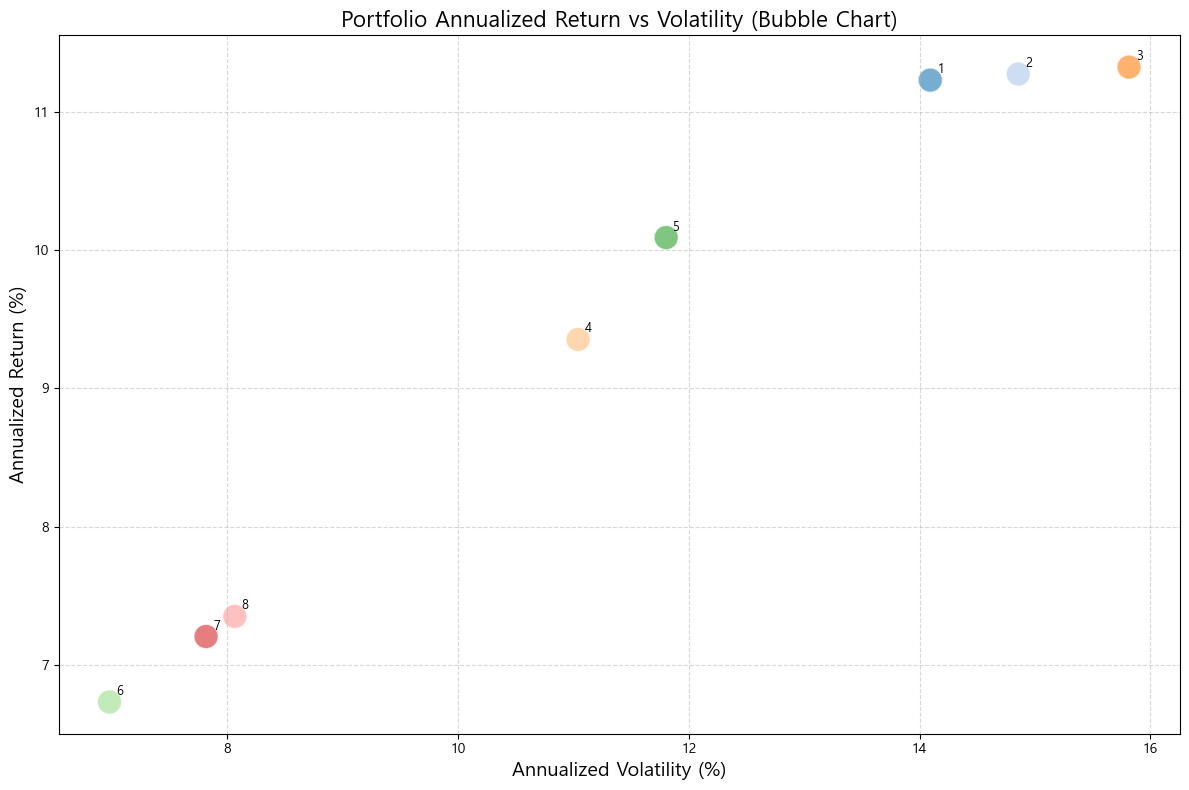

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bubble_chart(df_metrics):
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # 포트폴리오 이름 리스트
    portfolios = df_metrics['Portfolio']

    # x, y, size, color 지정
    x = df_metrics['Annualized Volatility (%)']
    y = df_metrics['Annualized Return (%)']
    size = np.full(len(df_metrics), 300)  # 버블 크기 고정값 (조절 가능)

    # 색상은 포트폴리오별로 구분 - colormap 사용
    cmap = plt.get_cmap('tab20')
    colors = cmap(np.arange(len(df_metrics)) % 20)

    scatter = ax.scatter(x, y, s=size, c=colors, alpha=0.6, edgecolors='w', linewidth=0.8)

    # 각 점에 포트폴리오 이름 라벨링
    for i, txt in enumerate(portfolios):
        ax.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

    ax.set_xlabel('Annualized Volatility (%)', fontsize=14)
    ax.set_ylabel('Annualized Return (%)', fontsize=14)
    ax.set_title('Portfolio Annualized Return vs Volatility (Bubble Chart)', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# 사용 예시
plot_bubble_chart(folio06_metrics)

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
from matplotlib.ticker import PercentFormatter, FormatStrFormatter
import numpy as np
from matplotlib.colors import Normalize

def plot_bubble_chart_v2(df_metrics):
    # 한글 폰트 설정 (Windows용 예시)
    mpl.rc('font', family='Malgun Gothic')
    mpl.rcParams['axes.unicode_minus'] = False

    # 스타일 설정
    plt.style.use('ggplot')

    # 버블 크기: Sharpe Ratio가 있을 경우 활용, 없으면 기본값으로 지정
    if 'Sharpe Ratio' in df_metrics.columns:
        bubble_size = df_metrics['Sharpe Ratio'] * 3600
        bubble_size = bubble_size.clip(lower=100)

        # 샤프 비율 값으로 Normalize 지정 (컬러맵 범위 고정)
        norm = Normalize(vmin=df_metrics['Sharpe Ratio'].min(), vmax=df_metrics['Sharpe Ratio'].max())
        colors = df_metrics['Sharpe Ratio']

    else:
        bubble_size = np.full(len(df_metrics), 300)
        norm = None
        colors = 'skyblue'

    plt.figure(figsize=(11, 8))
    ax = plt.gca()

    scatter = ax.scatter(
        df_metrics['Annualized Volatility (%)'] / 100,
        df_metrics['Annualized Return (%)'] / 100,
        s=bubble_size,
        c=colors,
        cmap='coolwarm',
        norm=norm,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5
    )

    # 컬러바 추가
    if norm is not None:
        cbar = plt.colorbar(scatter)
        cbar.set_label('Sharpe Ratio (샤프 지수)', fontsize=16)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # 포트폴리오 이름 텍스트 추가
    for _, row in df_metrics.iterrows():
        # Portfolio 값이 숫자형이면 정수로 변환해서 문자열 생성
        val = row['Portfolio']
        if isinstance(val, float) and val.is_integer():
            txt = str(int(val))
        else:
            txt = str(val)
    
        text = ax.text(
            row['Annualized Volatility (%)'] / 100,
            row['Annualized Return (%)'] / 100,
            txt,
            fontsize=20,
            fontweight='bold',
            color='black',
            ha='right',
            va='center'
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=4, foreground='white'),
            path_effects.Normal()
        ])

    # 축 % 포맷팅
    ax.xaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))

    # 축 범위 설정
    # ax.set_xlim(0.06, 0.20)
    # ax.set_ylim(0.06, 0.14)

    # 눈금 폰트 크기
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    # 라벨 및 타이틀
    ax.set_xlabel('Annualized Volatility (연 변동성, %)', fontsize=16)
    ax.set_ylabel('Annualized Return (연 수익률, %)', fontsize=16)
    ax.set_title('포트폴리오: 연 수익률 vs 변동성 (Sharpe Ratio 컬러)', fontsize=19)

    # 그리드 및 레이아웃
    ax.grid(True)
    plt.tight_layout()
    plt.show()

   Portfolio  Annualized Return (%)  Annualized Volatility (%)  Sharpe Ratio
0          1              11.227444                  14.092577      0.521496
1          2              11.271411                  14.855747      0.486236
2          3              11.321610                  15.815678      0.449959
3          4               9.353693                  11.039572      0.590347
4          5              10.089751                  11.803134      0.574818


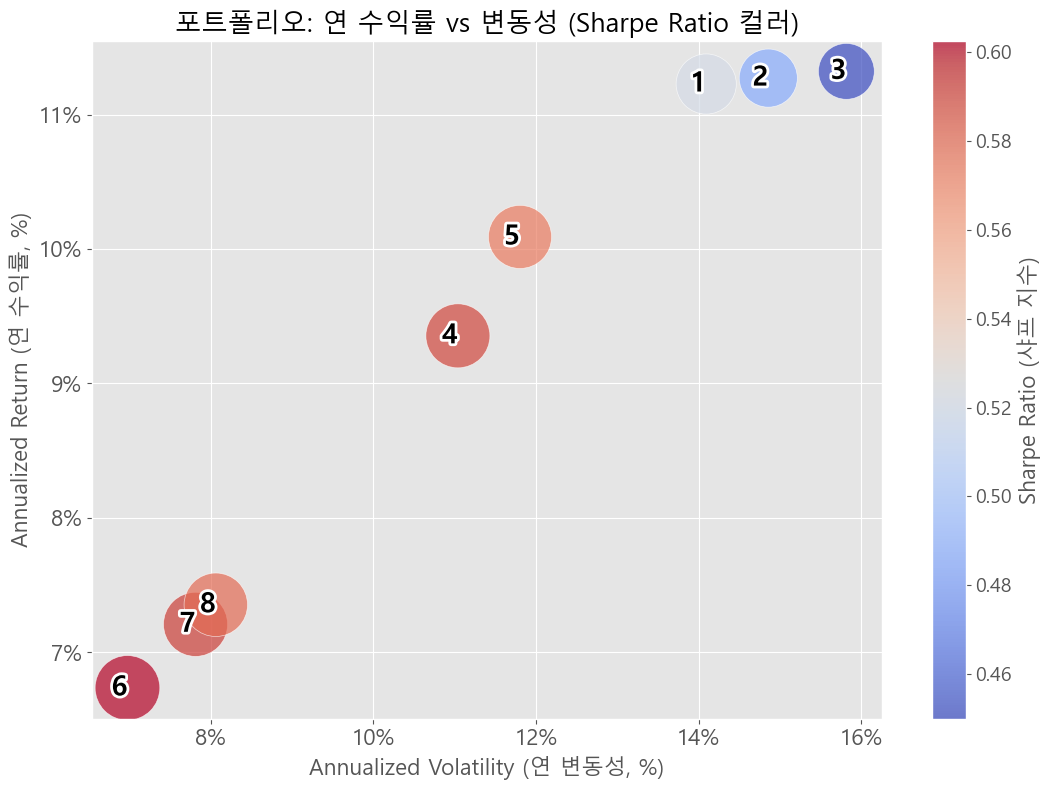

In [5]:
import pandas as pd

# 1) 연환산 수익률 및 변동성 데이터 불러오기
annual_metrics = pd.read_csv('portfolio06_annual_metrics.csv')

# 2) 샤프비율, 소르티노 비율 데이터 불러오기
ratios = pd.read_csv('portfolio06_ratios.csv')

# 3) 'Portfolio' 기준으로 병합
df_metrics = pd.merge(annual_metrics, ratios[['Portfolio', 'Sharpe Ratio']], on='Portfolio', how='left')

# 3.1) 병합한 데이터 CSV로 저장
df_metrics.to_csv('merged_portfolio06_metrics.csv', index=False)

# 4) 병합 결과 확인
print(df_metrics.head())

# 5) 시각화 함수 호출
plot_bubble_chart_v2(df_metrics)

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
from matplotlib.ticker import PercentFormatter, FormatStrFormatter
import numpy as np
from matplotlib.colors import Normalize

def plot_bubble_chart_v2(df_metrics):
    # 한글 폰트 설정 (Windows용 예시)
    mpl.rc('font', family='Malgun Gothic')
    mpl.rcParams['axes.unicode_minus'] = False

    # 스타일 설정
    plt.style.use('ggplot')

    # 버블 크기: Sharpe Ratio가 있을 경우 활용, 없으면 기본값으로 지정
    if 'Sharpe Ratio' in df_metrics.columns:
        bubble_size = df_metrics['Sharpe Ratio'] * 5800
        bubble_size = bubble_size.clip(lower=100)

        # 샤프 비율 값으로 Normalize 지정 (컬러맵 범위 고정)
        norm = Normalize(vmin=df_metrics['Sharpe Ratio'].min(), vmax=df_metrics['Sharpe Ratio'].max())
        colors = df_metrics['Sharpe Ratio']

    else:
        bubble_size = np.full(len(df_metrics), 300)
        norm = None
        colors = 'skyblue'

    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    scatter = ax.scatter(
        df_metrics['Annualized Volatility (%)'] / 100,
        df_metrics['Annualized Return (%)'] / 100,
        s=bubble_size,
        c=colors,
        cmap='coolwarm',
        norm=norm,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5
    )

    # 컬러바 추가
    if norm is not None:
        cbar = plt.colorbar(scatter)
        cbar.set_label('Sharpe Ratio (샤프 지수)', fontsize=16)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # 포트폴리오 이름 텍스트 추가
    for _, row in df_metrics.iterrows():
        # Portfolio 값이 숫자형이면 정수로 변환해서 문자열 생성
        val = row['Portfolio']
        if isinstance(val, float) and val.is_integer():
            txt = str(int(val))
        else:
            txt = str(val)
    
        text = ax.text(
            row['Annualized Volatility (%)'] / 100,
            row['Annualized Return (%)'] / 100,
            txt,
            fontsize=28,
            fontweight='bold',
            color='black',
            ha='right',
            va='center'
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=4, foreground='white'),
            path_effects.Normal()
        ])

    # 축 % 포맷팅
    ax.xaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))

    # 축 범위 설정
    ax.set_xlim(0.06, 0.165)
    ax.set_ylim(0.06, 0.118)

    # 눈금 폰트 크기
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    # 라벨 및 타이틀
    ax.set_xlabel('Annualized Volatility (연 변동성, %)', fontsize=16)
    ax.set_ylabel('Annualized Return (연 수익률, %)', fontsize=16)
    ax.set_title('포트폴리오: 연 수익률 vs 변동성 (Sharpe Ratio 컬러)', fontsize=19)

    # 그리드 및 레이아웃
    ax.grid(True)
    plt.tight_layout()
    plt.show()

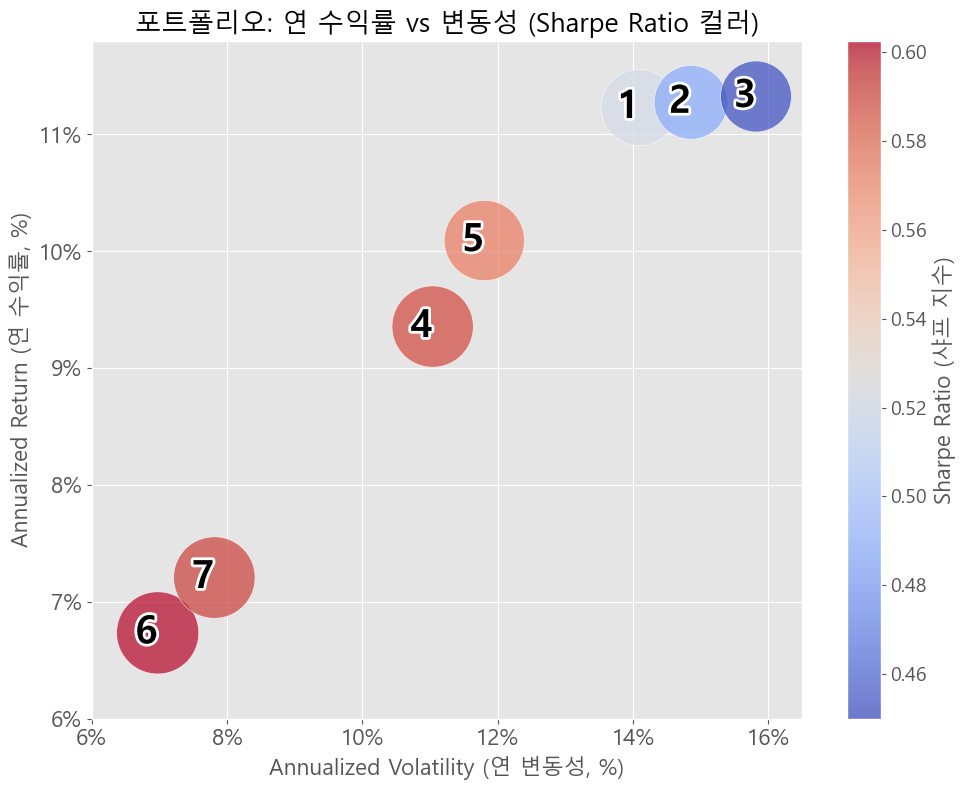

In [7]:
import pandas as pd

# 1) 연환산 수익률 및 변동성 데이터 불러오기
annual_metrics = pd.read_csv('portfolio06_annual_metrics.csv')

# 2) 샤프비율, 소르티노 비율 데이터 불러오기
ratios = pd.read_csv('portfolio06_ratios.csv')

# 3) 'Portfolio' 기준으로 병합
df_metrics = pd.merge(annual_metrics, ratios[['Portfolio', 'Sharpe Ratio']], on='Portfolio', how='left')

# 8, 9 제외한 데이터만 선택
filtered_df = df_metrics[~df_metrics['Portfolio'].isin([8, 9])]

# 필터된 데이터로 함수 호출
plot_bubble_chart_v2(filtered_df)